# Running our tail model on TCEs

Here we will take the tail model from `StackedTransitTail Model.ipynb` and we will apply it to all TCEs

In [2]:
# Imports

from astropy import units as u
from astropy import constants as c

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import exoplanet as xo
import theano.tensor as tt
import theano.tensor.extra_ops as ttx

import pandas as pd

import pymc3 as pm
%load_ext autoreload
%autoreload 2


In [153]:
# StackedTransitTail functions:
def getLDs(Teff,logg,n_samples,FeH=0.0,mission='tess',how='2'):
    Teff_samples = np.random.normal(Teff[0],np.average(abs(Teff[1:])),n_samples)
    logg_samples = np.random.normal(logg[0],np.average(abs(logg[1:])),n_samples)

    from scipy.interpolate import CloughTocher2DInterpolator as ct2d

    if mission[0].lower()=="t":
        import pandas as pd
        from astropy.io import ascii
        TessLDs=ascii.read('/Users/hosborn/Postdoc/MonoTools/data/tables/tessLDs.txt').to_pandas()
        TessLDs=TessLDs.rename(columns={'col1':'logg','col2':'Teff','col3':'FeH','col4':'L/HP','col5':'a',
                                           'col6':'b','col7':'mu','col8':'chi2','col9':'Mod','col10':'scope'})
        if FeH!=0.0:
            #Finding nearest by FeH:
            unq_FeHs=pd.unique(TessLDs['FeH'])
            TessLDs=TessLDs.loc[TessLDs['FeH']==unq_FeHs[np.argmin(abs(FeH-unq_FeHs.astype(float)))]]

        a_interp=ct2d(np.column_stack((TessLDs.Teff.values.astype(float),
                                       TessLDs.logg.values.astype(float))),
                      TessLDs.a.values.astype(float))
        b_interp=ct2d(np.column_stack((TessLDs.Teff.values.astype(float),
                                       TessLDs.logg.values.astype(float))),
                      TessLDs.b.values.astype(float))

        outarr=np.column_stack((a_interp(np.clip(Teff_samples,2300,12000),np.clip(logg_samples,0,5)),
                                b_interp(np.clip(Teff_samples,2300,12000),np.clip(logg_samples,0,5))))
        return outarr
    elif mission[0].lower()=="k":
        #Get Kepler Limb darkening coefficients.
        types={'1':[3],'2':[4, 5],'3':[6, 7, 8],'4':[9, 10, 11, 12]}
        if how in types:
            checkint = types[how]
            #print(checkint)
        else:
            print("no key...")

        arr = np.genfromtxt('/Users/hosborn/Postdoc/MonoTools/data/tables/KeplerLDlaws.txt',skip_header=2)
        #Selecting FeH manually:
        feh_ix=arr[:,2]==np.unique(arr[:, 2])[np.argmin(FeH-np.unique(arr[:, 2]))]
        a_interp=ct2d(np.column_stack((arr[feh_ix,0],arr[feh_ix,1])),arr[feh_ix,4])
        b_interp=ct2d(np.column_stack((arr[feh_ix,0],arr[feh_ix,1])),arr[feh_ix,5])
        outarr=np.column_stack((a_interp(np.clip(Teff_samples,3500,50000),np.clip(logg_samples,0,5)),
                                b_interp(np.clip(Teff_samples,3500,50000),np.clip(logg_samples,0,5))))
        return outarr
    elif mission.lower()=='corot':
        from astroquery.vizier import Vizier
        Vizier.ROW_LIMIT = -1
        arr = Vizier.get_catalogs('J/A+A/618/A20/COROTq')[0].to_pandas()
        a_interp=ct2d(np.column_stack((arr['Teff'],arr['logg'])),arr['a'])
        b_interp=ct2d(np.column_stack((arr['Teff'],arr['logg'])),arr['b'])
        outarr=np.column_stack((a_interp(np.clip(Teff_samples,3500,50000),np.clip(logg_samples,0,5)),
                                b_interp(np.clip(Teff_samples,3500,50000),np.clip(logg_samples,0,5))))
        return outarr

def RunModel(t_0, P, lc, 
             Rs, Ms, Teff, logg,
             n_steps=31, phase_coverage=0.2, init_planet_mass=0.025):
    '''
    #### Basic candidate params:
    # t_0 - time of transit
    # P - detected period
    # lc - dictionary lightcurve with time, flux, flux_err and mask
    #
    #### Stellar params from e.g. TIC:
    # Rs   - single value
    # Ms   - single value
    # Teff - np.array of [value, +err, -err]
    # logg - np.array of [value, +err, -err]
    #
    ####Default model hyper parameters:
    # n_steps - number of phantom dust planets to release from the surface. Needs to be high enough to not leave gaps between
    # phase_coverage - amount of the pre-transit phase from which to simulate dust. Needs to be high enough to accuratel model all dust but low enough to not cause problems with phantom orbits wrapping-around
    # init_planet_mass=0.025 Roughly 25% Mars mass - should be undetectably small yet big enough to have a big hill sphere.
    '''
    sma_circ    = (((c.G.value*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))
    
    #Getting limb darkening:
    ld_dists=getLDs(Teff,logg,n_samples=1200,mission='tess')
    ld_mult=1.0
    
    time = lc['time'][lc['mask']].astype(np.float32)
    flux = lc['flux_flat'][lc['mask']].astype(np.float32)
    flux_err = lc['flux_err'][lc['mask']].astype(np.float32)

    #Counting number of transits to model, and assigning time to each nearby transit:
    phase        = (time-t_0)/P
    rounded_phase= np.round(phase)
    trns_numbers = np.unique(rounded_phase)
    phase_index  = np.vstack([[rounded_phase==n_tr] for n_tr in trns_numbers])

    #Complex model:=
    with pm.Model() as model:
        #b can just be unit uniform:
        b=pm.Uniform('b',lower=0.0,upper=0.99)
        #This is no longer used, the offset was just 0.5P
        t_offset=pm.Bound(pm.Normal, upper=0.4*P,lower=-0.4*P)("t_offset", mu=0.0, sigma=0.05*P)

        #For now, let's just model lightcurve depth with two hyperparameters:
        # hyper-depth
        hyper_logdepth_mu = pm.Uniform('hyper_logdepth_mu', lower=-10, upper=-0.7) # lower np.log(30*1e-6), uppper np.log(0.5*1e-6)
        hyper_logdepth_sigma = pm.HalfNormal('hyper_logdepth_sigma', sigma=5) # sigma half of the mu range

        # log_rpl
        log_depths = pm.Bound(pm.Normal, upper=-0.7,lower=-10)('log_depths',
                                                               mu=hyper_logdepth_mu, 
                                                               sigma=hyper_logdepth_sigma, 
                                                               shape=len(trns_numbers))

        #This is the relative speed of the dust with respect to the planet. i.e. <0 = in-falling. >0 = propelled outward.
        #NB - dust_vel<0.41 (as sqrt(2)*v_circ = unbound from the solar system!).    
        dust_vel=pm.Bound(pm.Normal, upper=0.3,lower=-0.3)('dust_vel',mu=0.0,sd=0.2)

        #We want to define our dusty "phantom planets" as kicked off their planet and moving along eccentric orbits
        #Here we will assume the dust is kicked off _radially_ with no change in angular velocity
        #This means all the orbits will have the same eccentricity, and the same "period", so initialising here:
        # Initial positions of the orbits of our phantom planets (where pi/2 = planet phase)
        #sma_circ    = pm.Constant("sma_circ", (((c.G.value*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m)))
        sma_circ    = (((c.G.value*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))
        #v_circ      = pm.Constant("v_circ", (2*np.pi*sma_circ*(u.AU.to(u.m)))/(P*86400))
        v_circ      = (2*np.pi*sma_circ*(u.AU.to(u.m)))/(P*86400)
        sma_phantom = pm.Deterministic("sma_phantom",((2/(sma_circ*(u.AU.to(u.m))) - (v_circ**2 + (dust_vel*v_circ)**2)/(c.G.value*Ms*(u.Msun.to(u.kg))))**-1)*(u.m.to(u.AU)))
        #sma_phantom = 1/(u.AU.to(u.m)*(2/(sma_circ*u.AU.to(u.m)) - ((1+dust_vel)*v_circ)**2/(c.G.value*Ms*(u.Msun.to(u.kg)))))
        per_phantom = pm.Deterministic("per_phantom",P*(sma_phantom/sma_circ)**(3/2))

        #Defining t_periasteron as the time when the phatom planet left the real planet in the preceeding part of the orbit
        # We have to redefine t_periasteron like this because we specifically want to model the fact that dust knocked off the surface *does not arrive at the time of transit*
        #In the case of an in-falling dust body, we need to flip this by pi as periasteron becomes apasteron 
        ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(abs(sma_circ/sma_phantom-1)))
        '''
        if tt.lt(sma_phantom,sma_circ):
            ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(1-sma_circ/sma_phantom))
        elif tt.gt(sma_phantom,sma_circ):
            ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(sma_circ/sma_phantom-1))
        else:
            ecc_phantom = pm.Deterministic("ecc_phantom",0.0)
        '''

        #NB - similarly, the dust velocity should be on a trajectory that doesnt intersect with the star (because this ruins the transit models)
        # Uses a sigmoid function L/(1+exp(K*(sma-sma_min))), where L=-100 (invalid sma) and K=1000 (steepness)
        sma_min=pm.Potential("sma_min",-100.0/(1+np.exp(1000*(sma_phantom-Rs*(u.Rsun.to(u.au))/(1-ecc_phantom)))))

        if tt.lt(dust_vel,0):
            phantom_omega   = np.linspace(1.5*np.pi,1.5*np.pi - phase_coverage*2*np.pi,  n_steps)
            phantom_t_peris = 0.5*per_phantom - np.linspace(0.0, phase_coverage*P, n_steps)
        elif tt.ge(dust_vel,0):
            phantom_omega   = np.linspace(0.5*np.pi, 0.5*np.pi - phase_coverage*2*np.pi, n_steps)
            phantom_t_peris = np.linspace(0.0, phase_coverage*P, n_steps)

        '''
        if tt.lt(dust_vel,0):
            ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(sma_circ/sma_phantom-1))
            phantom_omega   = pm.Deterministic("phantom_omega", np.linspace(1.5*np.pi - phase_coverage*2*np.pi, 1.5*np.pi, n_steps) )
            phantom_t_peris = pm.Deterministic("phantom_t_peris", 0.5*per_phantom - np.linspace(phase_coverage*P, 0.0, n_steps))
        elif tt.gt(dust_vel,0):
            ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(1-sma_circ/sma_phantom))
            phantom_omega = pm.Deterministic("phantom_omega", np.linspace(0.5*np.pi - phase_coverage*2*np.pi, 0.5*np.pi, n_steps) )
            phantom_t_peris = pm.Deterministic("phantom_t_peris", np.linspace(-1*phase_coverage*P, 0.0, n_steps))
        else:
            ecc_phantom = pm.Deterministic("ecc_phantom",0.0)
            phantom_omega = pm.Deterministic("phantom_omega", np.linspace(0.5*np.pi - phase_coverage*2*np.pi, 0.5*np.pi, n_steps) )
            phantom_t_peris = pm.Deterministic("phantom_t_peris", np.linspace(-1*phase_coverage*P, 0.0, n_steps))
        '''
        #As dust dispersion is constant and our steps are constant, we should also always have the same dispersion for each transit, so initialising here:
        init_planet_ratio = ((sma_circ*u.AU.to(u.m))*(init_planet_mass*(u.Mearth.to(u.kg))/(3*Ms*(u.Msun.to(u.kg))))**(1/3))/(Rs*(u.Rsun.to(u.m))) #roche lobe for Mars-sized body on this orbit
        log_rad_growth    = pm.Uniform("log_rad_growth",lower=-10,upper=10,testval=-1)
        # We parameterize the rate of growth of the dusty "planets" with log_rad_growth
        planet_ratios_init= init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(1,2,n_steps)
        planet_ratios     = pm.Deterministic("planet_ratios",(planet_ratios_init-planet_ratios_init[0])/(3.5*planet_ratios_init[-1])+init_planet_ratio) #Limiting it at 0.5
        #Limiting it at 0.5

        # Dispersion is the parameter dealing with the net throughput of each dust "planet"
        # We will start at 0.25 for the Hill Sphere and decrease
        # How steep that decrease is can be varied with "log_dust_dispersion"
        log_dust_dispersion=pm.Uniform("log_dust_dispersion",lower=2,upper=10)
        dispersion        = pm.Deterministic("dispersion", 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps)))

        #Defining limb darkening
        u_star_tess = pm.Bound(pm.Normal, lower=0.0, upper=1.0)("u_star_tess", 
                                        mu=np.clip(np.nanmedian(ld_dists,axis=0),0,1),
                                        sd=np.clip(ld_mult*np.nanstd(ld_dists,axis=0),0.05,1.0),
                                        shape=2, testval=np.clip(np.nanmedian(ld_dists,axis=0),0,1))

        #u_star_tess = xo.distributions.QuadLimbDark("u_star_tess", testval=np.array([0.3, 0.2]))

        #Defining the orbit using stellar params (Rs, Ms) and period, omega, t_peri, ecc and b:
        orbit = xo.orbits.KeplerianOrbit(r_star=Rs,m_star=Ms,
                                         period=tt.tile(per_phantom,n_steps),
                                         omega=phantom_omega,
                                         t_periastron=phantom_t_peris,
                                         ecc=tt.tile(ecc_phantom,n_steps),
                                         b=tt.tile(b,n_steps))

        #Getting the lightcurve for all orbits, for all times (where the times have been adjusted to be ~0)
        lc = xo.LimbDarkLightCurve(u_star_tess).get_light_curve(orbit=orbit,r=planet_ratios,
                                                                t=t_offset+tt.clip(P*(phase-np.round(phase)),-0.5*per_phantom,0.5*per_phantom))
        #For short-period orbits, we really need to make sure that the second orbits are not included...
        #lc[((P*(phase-np.round(phase))[:,np.newaxis]<orbit.t0.dimshuffle('x',0)-0.5*per_phantom)+(P*(phase-np.round(phase))[:,np.newaxis]>orbit.t0.dimshuffle('x',0)+0.5*per_phantom))]=0

        #Incorporating dispersion and finding the minimum in order to normalise lightcurve to depth=1.0
        disp_lc = tt.sum(lc*dispersion.dimshuffle('x',0),axis=1)
        lc_min  = tt.clip(tt.min(disp_lc),-1e5,-1e-20)

        #Incorporating depth differences by multipliying depths (N_Tr, 1) by a phase index (N_tr x N_lc) and summing along N_tr axis:
        depth_adjusts = tt.sum(tt.exp(log_depths).dimshuffle(0,'x')*phase_index,axis=0)

        #Multiplying normalised lc by the depth:
        model_lc = pm.Deterministic("model_lc",-1*(disp_lc/lc_min)*depth_adjusts)

        #Likelihood of the model:
        pm.Normal("likelihood",mu=model_lc, sigma=flux_err, observed=flux)
        llk = pm.Deterministic("llk", model.logpt)

    #Minimisizing the model:
    with model:
        map_estimate = pm.find_MAP(model=model, method="powell")
    out={}
    full_model_cols=['b', 't_offset', 'dust_vel', 'sma_phantom', 'per_phantom',
                'hyper_logdepth_mu','hyper_logdepth_sigma','ecc_phantom','sma_min',
                'log_rad_growth', 'log_dust_dispersion', 'u_star_tess','llk']
    for col in full_model_cols:
        if col=='u_star_tess':
            out['full_'+col+'0']=map_estimate[col][0]
            out['full_'+col+'1']=map_estimate[col][1]
        else:
            out['full_'+col]=map_estimate[col]

        

    with pm.Model() as simple_model:
        #b can just be unit uniform:
        simple_b=pm.Uniform('simple_b',lower=0.0,upper=0.95)
        #This is no longer used, the offset was just 0.5P
        simple_t_offset=pm.Bound(pm.Normal, upper=0.4*P,lower=-0.4*P)("simple_t_offset", mu=0.0, sigma=0.05*P)

        # log_rpl
        simple_log_rprs = pm.Uniform('simple_log_rprs', upper=np.log(0.33),lower=np.log(1e-3))

        simple_u_star_tess = pm.Bound(pm.Normal, lower=0.0, upper=1.0)("simple_u_star_tess", 
                                        mu=np.clip(np.nanmedian(ld_dists,axis=0),0,1),
                                        sd=np.clip(ld_mult*np.nanstd(ld_dists,axis=0),0.05,1.0),
                                        shape=2, testval=np.clip(np.nanmedian(ld_dists,axis=0),0,1))

        #Defining the orbit using stellar params (Rs, Ms) and period, t_0 and b:
        orbit = xo.orbits.KeplerianOrbit(r_star=Rs, m_star=Ms, period=P, t0=t_0+simple_t_offset, b=simple_b)

        simple_lc=xo.LimbDarkLightCurve(simple_u_star_tess).get_light_curve(orbit=orbit, r=tt.exp(simple_log_rprs), t=time)
        simple_model_lc = pm.Deterministic("simple_model_lc", simple_lc)

        #Likelihood of the model:
        pm.Normal("simple_likelihood", mu=simple_model_lc, sigma=flux_err[:,np.newaxis], observed=flux[:,np.newaxis])
        simple_llk = pm.Deterministic("simple_llk", simple_model.logpt)

    #Minimisizing the model:

    with simple_model:
        simple_map_estimate = pm.find_MAP(model=simple_model, method="powell")

    simple_model_cols=['simple_b','simple_log_rprs','simple_u_star_tess','simple_t_offset','simple_llk']
    for col in simple_model_cols:
        if col=='simple_u_star_tess':
            out[col+'0']=simple_map_estimate[col][0]
            out[col+'1']=simple_map_estimate[col][1]
        else:
            out[col]=simple_map_estimate[col]

    out['delta_llk'] = out['full_llk']-out['simple_llk']
    out['delta_bic'] = (9 - 5)*np.log(len(time)) - 2*out['delta_llk']
    
    models=np.column_stack((time,flux,flux_err,phase,map_estimate["model_lc"],simple_map_estimate["simple_model_lc"]))
    
    return out, models


In [97]:
tces_list=pd.read_html("http://archive.stsci.edu/tess/bulk_downloads/bulk_downloads_tce.html")[0]
tces_list.columns=['start','stop','csv']
tces_list=tces_list.iloc[:-2]

In [68]:
all_tces=pd.DataFrame()
from astropy.io import ascii

for row in tces_list.iterrows():
    tce_sect=ascii.read("http://archive.stsci.edu/missions/tess/catalogs/tce/"+row[1]['csv']).to_pandas()
    tce_sect['Sectors']=','.join(list(np.arange(int(row[1]['start'][7:]),0.001+int(row[1]['stop'][7:])).astype(int).astype(str)))
    all_tces=all_tces.append(tce_sect)

In [65]:
all_tces.columns

Index(['tceid', 'ticid', 'planetNumber', 'planetCandidateCount',
       'starTeffKelvin', 'starLoggCgs', 'orbitalPeriodDays',
       'orbitalPeriodDays_err', 'planetRadiusEarthRadii',
       'planetRadiusEarthRadii_err', 'ratioPlanetRadiusToStarRadius',
       'ratioSemiMajorAxisToStarRadius', 'semiMajorAxisAu',
       'starRadiusSolarRadii', 'transitDepthPpm', 'transitDepthPpm_err',
       'transitDurationHours', 'transitEpochBtjd', 'transitEpochBtjd_err',
       'transitIngressTimeHours', 'minImpactParameter', 'ws_mes',
       'ws_mesphase', 'expectedtransitcount', 'chiSquare2', 'mes', 'maxses',
       'equilibriumTempKelvin', 'InsolationFlux', 'Sectors'],
      dtype='object')

In [190]:
all_tces=all_tces.set_index(np.arange(len(all_tces)))

In [191]:
tces  = all_tces.loc[(all_tces['orbitalPeriodDays']<1.5) & \
                     (all_tces['transitDepthPpm']<12.5e3) & \
                     ((all_tces['semiMajorAxisAu']/0.0046504673)>all_tces['starRadiusSolarRadii']) & \
                     (all_tces['planetRadiusEarthRadii']<10)]

In [192]:
all_tces.to_csv("Unfiltered_TCES.csv")
tces.to_csv("Filtered_TCES.csv")

In [72]:
from MonoTools.MonoTools import tools, starpars

In [77]:
from astropy.coordinates import SkyCoord

In [193]:
tces_out=pd.DataFrame()

In [ ]:
for i,cand in tces.iterrows():
    if i not in tces_out.index.values:
        lc, hdr = tools.TESS_lc(cand['ticid'],np.array(cand['Sectors'].split(',')).astype(int),use_ppt=False)
        lc['phase']=(lc['time']-cand['transitEpochBtjd']-0.5*cand['orbitalPeriodDays'])%cand['orbitalPeriodDays']-0.5*cand['orbitalPeriodDays']
        transit_mask=abs(lc['phase'])>(cand['transitDurationHours']/48)
        lc = tools.lcFlatten(lc,winsize=0.9*cand['orbitalPeriodDays'],
                             stepsize=0.05*cand['orbitalPeriodDays'],transit_mask=transit_mask)
        radec=SkyCoord(hdr['RA_OBJ']*u.deg, hdr['DEC_OBJ']*u.deg)
        info,_,_=starpars.getStellarInfoFromCsv(cand['ticid'],'tess',radec=radec)
        Rstar   = [float(info['rad']),float(info['eneg_rad']),float(info['epos_rad'])]
        Teff    = [float(info['teff']),float(info['eneg_teff']),float(info['epos_teff'])]
        logg    = [float(info['logg']),float(info['eneg_logg']),float(info['epos_logg'])]
        rhostar = [float(info['rho']),float(info['eneg_rho']),float(info['epos_rho'])]
        FeH     = 0.0 if 'FeH' not in info else float(info['FeH'])
        if 'mass' in info:
            Ms=float(info['mass'])
        else:
            Ms=rhostar[0]*Rstar[0]**3
        
        out, models = RunModel(cand['transitEpochBtjd'], cand['orbitalPeriodDays'], lc, 
                       Rstar[0], Ms, np.array(Teff), np.array(logg))
        np.savetxt(str(cand['tceid'])+"_lightcurve.csv",models)
        out['RA']=hdr['RA_OBJ']
        out['DEC']=hdr['DEC_OBJ']
        tces_out=tces_out.append(tces.loc[i].append(pd.Series(out,name=i)))
        print(cand['tceid'],"llk simple:", out['simple_llk'],"llk full:", out['full_llk'], 
              ['simple model fits better' if out['delta_llk']<0 else 'full model fits better'])
        #Saving to file:
        tces_out.to_csv("TCE_table_fit_results.csv")

[26] <class 'numpy.ndarray'>
TESS file
16941
994 points masked in lc of 17909
transit mask: <class 'numpy.ndarray'> 17248 0 <class 'numpy.ndarray'> 17248 True
Breaking because status = COMPLETE
TESS object


logp = 86,708, ||grad|| = 7.0774e+07: : 5001it [08:14, 10.11it/s]                             

logp = 86,126, ||grad|| = 88.959: 100%|██████████| 74/74 [00:00<00:00, 431.98it/s]  


00007772500-01 llk simple: 86095.01509955683 llk full: 86521.42940469638 ['full model fits better']
[26] <class 'numpy.ndarray'>
TESS file
16942
987 points masked in lc of 17909
transit mask: <class 'numpy.ndarray'> 17248 0 <class 'numpy.ndarray'> 17248 True
Breaking because status = COMPLETE
TESS object


logp = 72,826, ||grad|| = 513.09: : 5001it [10:16,  8.11it/s]                         

logp = 72,424, ||grad|| = 379.75: 100%|██████████| 177/177 [00:00<00:00, 435.61it/s] 


00018422438-01 llk simple: 72418.13059695248 llk full: 72766.89099454448 ['full model fits better']
[26] <class 'numpy.ndarray'>
TESS file
16942
987 points masked in lc of 17909
transit mask: <class 'numpy.ndarray'> 17248 0 <class 'numpy.ndarray'> 17248 True
Breaking because status = COMPLETE
TESS object


logp = 67,406, ||grad|| = 15,344: : 5001it [10:18,  8.09it/s]                         

logp = 71,645, ||grad|| = 129.17: 100%|██████████| 186/186 [00:00<00:00, 409.39it/s]  


00018422438-02 llk simple: 71638.20774499048 llk full: 67332.99596366062 ['simple model fits better']
[26] <class 'numpy.ndarray'>
TESS file
16941
996 points masked in lc of 17909
transit mask: <class 'numpy.ndarray'> 17248 0 <class 'numpy.ndarray'> 17248 True
Breaking because status = COMPLETE
TESS object


logp = -inf, ||grad|| = 1.7421e+12: 100%|██████████| 2637/2637 [17:13<00:00,  2.55it/s]       
logp = 1.0008e+05, ||grad|| = 0.005516: 100%|██████████| 287/287 [00:01<00:00, 211.95it/s] 


00020534584-02 llk simple: 99952.94742209889 llk full: -inf ['simple model fits better']
[26] <class 'numpy.ndarray'>
TESS file
16942
991 points masked in lc of 17909
transit mask: <class 'numpy.ndarray'> 17248 0 <class 'numpy.ndarray'> 17248 True
Breaking because status = COMPLETE
TESS object


logp = 93,452, ||grad|| = 18.026: 100%|██████████| 2978/2978 [13:46<00:00,  3.60it/s]     
logp = 93,434, ||grad|| = 282.77: 100%|██████████| 232/232 [00:00<00:00, 297.62it/s]  


00021125485-01 llk simple: 93426.31087982444 llk full: 93287.09450024884 ['simple model fits better']
[26] <class 'numpy.ndarray'>
TESS file
16942
970 points masked in lc of 17909
transit mask: <class 'numpy.ndarray'> 17248 0 <class 'numpy.ndarray'> 17248 True
Breaking because status = COMPLETE
TESS object


logp = -4.0023e+05, ||grad|| = 1.6587e+05:  45%|████▌     | 2258/5000 [03:12<03:31, 12.98it/s]

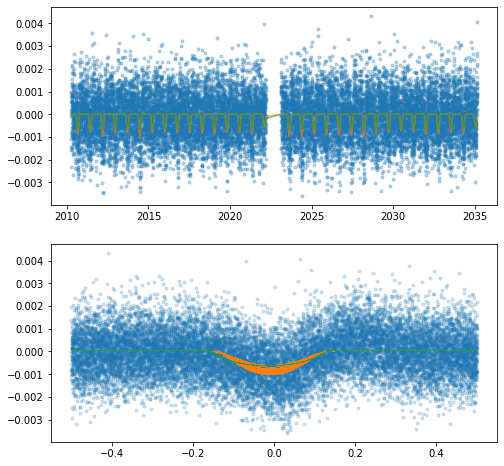

In [184]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(models[:,0],models[:,1],'.',alpha=0.3)
plt.plot(models[:,0],models[:,4],alpha=0.6)
plt.plot(models[:,0],models[:,5],alpha=0.6)
plt.subplot(212)
plt.plot((models[:,3]-0.5)%1-0.5,models[:,1],'.',alpha=0.2)
plt.plot((models[np.argsort(models[:,3]),3]-0.5)%1-0.5,models[np.argsort(models[:,3]),4],',')
plt.plot((models[np.argsort(models[:,3]),3]-0.5)%1-0.5,models[np.argsort(models[:,3]),5],',')

In [188]:
tces_out['delta_llk']

10             NaN
10             NaN
10             NaN
10             NaN
10             NaN
10             NaN
10             NaN
10             NaN
10   -1.866560e+13
37             NaN
37             NaN
37             NaN
37             NaN
37             NaN
37             NaN
37             NaN
37             NaN
37             NaN
37             NaN
37    3.484684e+02
38             NaN
38             NaN
38             NaN
38             NaN
38             NaN
38             NaN
38             NaN
38   -8.391297e+01
47             NaN
47             NaN
47             NaN
47             NaN
47             NaN
47             NaN
47             NaN
47             NaN
47             NaN
47            -inf
49             NaN
49             NaN
49             NaN
49             NaN
49             NaN
49   -2.242797e+02
Name: delta_llk, dtype: float64

In [189]:
tces.loc[i].append(pd.Series(out,name=i))

,tceid,ticid,planetNumber,planetCandidateCount,starTeffKelvin,starLoggCgs,orbitalPeriodDays,orbitalPeriodDays_err,planetRadiusEarthRadii,planetRadiusEarthRadii_err,...,full_sma_phantom,full_t_offset,full_u_star_tess0,full_u_star_tess1,simple_b,simple_llk,simple_log_rprs,simple_t_offset,simple_u_star_tess0,simple_u_star_tess1
49,00021125485-01,21125485.0,1.0,1.0,6041.00,3.43140,0.761900,0.000113,7.40552,3.65692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,00028304903-01,28304903.0,1.0,2.0,6518.15,4.20147,0.332558,0.000024,2.11337,0.40132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,00132445617-01,132445617.0,1.0,2.0,9359.00,4.10740,0.369257,0.000014,5.09902,1.54853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,00013212836-01,13212836.0,1.0,3.0,5780.00,4.43800,1.013350,0.000020,1.51452,1.72170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,00141757920-02,141757920.0,2.0,2.0,7369.05,4.03772,0.327708,0.000009,4.66057,1.81071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.016954007540525916,0.007265728364707291,1.0,0.258557,0.8743962674503268,93426.25208185143,-2.326575353202304,-0.01134880963031537,0.586201,0.532479


In [181]:
np.average((models[:,1]-models[:,5])**2/models[:,2]**2)

0.9013410182694589

In [182]:
np.average((models[:,1]-models[:,4])**2/models[:,2]**2)

0.9017634519489616

In [167]:
out

{'full_b': array(5.24272681e-13),
 'full_t_offset': array(0.02104882),
 'full_dust_vel': array(-0.06385082),
 'full_sma_phantom': array(0.01329761),
 'full_per_phantom': array(0.55457297),
 'full_hyper_logdepth_mu': array(-7.6101587),
 'full_hyper_logdepth_sigma': array(1.207551e-07),
 'full_ecc_phantom': array(0.06385082),
 'full_log_rad_growth': array(10.),
 'full_log_dust_dispersion': array(2.),
 'full_u_star_tess0': 1.0,
 'full_u_star_tess1': 0.19281301389546865,
 'full_llk': array(-1.86655978e+13),
 'simple_b': array(2.09711772e-07),
 'simple_log_rprs': array(-3.94230799),
 'simple_u_star_tess0': 0.36170057211228135,
 'simple_u_star_tess1': 0.20236678655986512,
 'simple_t_offset': array(-0.01765568),
 'simple_llk': array(86105.7455602),
 'delta_llk': -18665597847807.83,
 'delta_bic': 37331195695654.6,
 'RA': 274.193701507207,
 'DEC': 47.1161935483658}

In [176]:
map_estimate

{'b_interval__': array(0.12504874),
 't_offset_interval__': array(0.00260725),
 'hyper_logdepth_mu_interval__': array(-0.03717202),
 'hyper_logdepth_sigma_log__': array(-0.26288318),
 'log_depths_interval__': array([ 0.38108195,  0.00358884,  0.23406519, -0.28926092,  0.17086535,
        -0.28215283,  0.37412581, -0.31949371,  0.24466418, -0.62726457,
        -0.33123481, -0.56706281,  0.23251587, -0.34593378,  0.19872682,
         0.29716896]),
 'dust_vel_interval__': array(0.05326055),
 'log_rad_growth_interval__': array(46.44396655),
 'log_dust_dispersion_interval__': array(-41.20635893),
 'u_star_tess_interval__': array([ 0.00660338, -1.51172008]),
 'b': array(0.5259093),
 't_offset': array(0.0003408),
 'hyper_logdepth_mu': array(-5.43641499),
 'hyper_logdepth_sigma': array(0.7688317),
 'log_depths': array([-4.47455352, -5.34165596, -4.80826946, -6.0178812 , -4.95370174,
        -6.00168764, -4.49016346, -6.08656799, -4.78397651, -6.76238126,
        -6.11315608, -6.63419196, -4.81

In [174]:
out['full_sma_phantom'],Rstar[0]*(u.Rsun.to(u.au))/(1-out['full_ecc_phantom']),-100.0/(1+np.exp(1000*(out['full_sma_phantom']-Rs*(u.Rsun.to(u.au))/(1-out['full_ecc_phantom']))))


(array(0.01329761), 0.004841179671669022, -0.004238672773365819)

In [158]:
models[:,3]

array([-0.39997274, -0.39753661, -0.39487895, ..., 44.7101326 ,
       44.71256638, 44.71500397])

In [111]:
Rstar, Teff, Ms, logg, cand['transitEpochBtjd'], cand['orbitalPeriodDays']

([0.97454, 0.0502015, 0.0502608],
 [5717.0, 144.077, 105.13],
 1.02,
 [4.46907, 0.0975436, 0.0591854],
 2010.49,
 0.551185)

(2010.4, 2011.0)

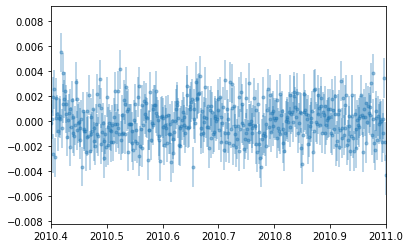

In [105]:
plt.errorbar(lc['time'][lc['mask']],lc['flux_flat'][lc['mask']],yerr=lc['flux_err'][lc['mask']],fmt='.',alpha=0.4)
plt.xlim(2010.4,2011)

KeyboardInterrupt: 

In [127]:
simple_map_estimate['simple_b']

array(0.42824115)